In [43]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains.question_answering import load_qa_chain
from langchain.chains import ConversationalRetrievalChain
from langchain_community.embeddings import OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

In [44]:
local_path = "Corpus.pdf"

loader = PyPDFLoader(local_path)
pages = loader.load_and_split()
print(pages[0])

page_content='Jessup\nCellars\nCorpus\nJessup\nCellars\nInformation\nJessup\nCellars\nhas\na\ncasual\nand\ninviting\natmosphere\nand\nwas\nthe\nfirst\ntasting\nroom\nopened\nin\nYountville\nin\n2003.\nYou\nhave\nthe\noption\nof\nsitting\ninside\nour\nstunning\nart\ngallery\nor\nyou\nmay\nchoose\nto\nenjoy\nthe\npatio\nwith\ngiant\numbrellas.\nWe\nalso\nhave\nspace\navailable\nfor\nprivate\ngroups\nand\nspecial\naccommodations\nand\nsnacks\nfor\nyour\nchildren.\nOur\nfine\nart\nis\nmeticulously\ncurated\nby\nour\nlead\nartist\nJermaine\nDante\nwho\nexhibits\nhis\ncolorful\ncreations\nin\nlarge\nformats\nin\nour\nspacious\ngallery\nwhere\nyou\ncan\ntake\nin,\nor\ntake\nhome\nthe\ninspiring\nart\nwhile\nimbibing\nyour\nfavorite\nJessup\nwines.\nBOTH\nSEASONED\nWINE\nLOVERS,\nAND\nTHOSE\nJUST\nLEARNING\nABOUT\nWINE,\nARE\nEMBRACED\nAND\nWELCOMED\nAT\nJESSUP\nCELLARS.\nLocated\njust\na\nblock\nnorth\nfrom\nthe\nfamed\nThe\nFrench\nLaundry\nin\nthe\nquaint\nvillage\nof\nYountville,\nour\nwin

In [45]:
chunks = pages

In [46]:

import textract
doc = textract.process(local_path)

with open('corpus_1.txt', 'w') as f:
    f.write(doc.decode('utf-8'))

with open('corpus_1.txt', 'r') as f:
    text = f.read()




def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))


text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

Token indices sequence length is longer than the specified maximum sequence length for this model (1138 > 1024). Running this sequence through the model will result in indexing errors


In [47]:
type(chunks[0]) 

langchain_core.documents.base.Document

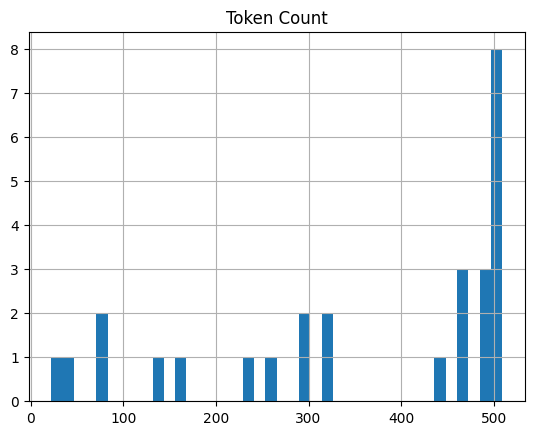

In [48]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

In [49]:
vector_db = Chroma.from_documents(
    documents=chunks, 
    embedding=OllamaEmbeddings(model="nomic-embed-text",show_progress=True),
    collection_name="local-rag"
)

OllamaEmbeddings: 100%|██████████| 27/27 [00:03<00:00,  7.16it/s]


In [50]:
query = "What is corpus"
docs = vector_db.similarity_search(query)
docs[0]

OllamaEmbeddings: 100%|██████████| 1/1 [00:00<00:00, 181.13it/s]


Document(page_content='sometimes for many years or even decades. Overall, the Solera method is a meticulous and\ntime-honored process that results in complex, well-balanced dessert wines with layers of flavor and\naroma.')

In [51]:
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.chat_models import ChatOllama
from langchain_core.runnables import RunnablePassthrough
from langchain.retrievers.multi_query import MultiQueryRetriever

In [52]:
# LLM from Ollama
local_model = "mistral"
llm = ChatOllama(model=local_model)

In [53]:
QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from
    a vector database. By generating multiple perspectives on the user question, your
    goal is to help the user overcome some of the limitations of the distance-based
    similarity search. Provide these alternative questions separated by newlines.
    Original question: {question}""",
)

In [54]:
retriever = MultiQueryRetriever.from_llm(
    vector_db.as_retriever(), 
    llm,
    prompt=QUERY_PROMPT
)

# RAG prompt
template = """Answer the question based ONLY on the following context:
{context}
Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

In [55]:
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [56]:
chain.invoke(input(""))

OllamaEmbeddings: 100%|██████████| 1/1 [00:00<00:00, 15.87it/s]


" Hello! How can I help you today? Here's some information about the places and activities mentioned in the context you provided:\n\n1. The Napa Valley Lodge offers concierge services, meeting and event space, and is located with a picturesque view of Grgich Hills vineyards.\n2. Jessup Cellars is a winery that offers wine club memberships with three options (Tasting Club, My Jessup Cellar 6, My Jessup Cellar 12) and features a tasting room and gallery in Yountville, California. They also have resident artist Jermaine Danté currently displaying his artwork there.\n3. The Kitchen at Priest Ranch is a restaurant located in Napa Valley that serves seasonal American cuisine.\n4. RH Yountville is a location with an unknown context provided in the text.\n5. The area of Yountville, California, is known for its wineries and vineyards, as well as being easily accessible from multiple airports including SFO, Oakland, Sacramento, and Santa Rosa. Jessup Cellars is dog-friendly and welcomes well-beh